Import dependencies:

In [22]:
from typing import Tuple, List, Iterable
from pydot import Dot, graph_from_dot_data, Edge
from graphviz.graphs import BaseGraph
from graphviz import Source
import amrlib
from amrlib.graph_processing.amr_plot import AMRPlot
import numpy as np
import pandas as pd
import csv, pickle
from tqdm.notebook import tqdm

Extract nodes and edges from AMR graphs.

In [23]:
def get_graph_dot_obj(graph_spec) -> List[Dot]:
    """Get a dot (graphs) object list from a variety 
    of possible sources (postelizing inputs here)"""
    _original_graph_spec = graph_spec
    if isinstance(graph_spec, (BaseGraph, Source)):
        # get the source (str) from a graph object
        graph_spec = graph_spec.source
    if isinstance(graph_spec, str):
        # get a dot-graph from dot string data
        graph_spec = graph_from_dot_data(graph_spec)
    # make sure we have a list of Dot objects now
    assert isinstance(graph_spec, list) and all(
        isinstance(x, Dot) for x in graph_spec
    ), (
        f"Couldn't get a proper dot object list from: {_original_graph_spec}. "
        f"At this point, we should have a list of Dot objects, but was: {graph_spec}"
    )
    return graph_spec

def get_edges(graph_spec, label = False):
    """Get a list of edges for a given graph (or list of lists thereof).
    If ``postprocess_edges`` is ``None`` the function will return ``pydot.Edge`` objects from
    which you can extract any information you want.
    By default though, it is set to extract the node pairs for the edges, and you can
    replace with any function that takes ``pydot.Edge`` as an input.
    """
    graphs = get_graph_dot_obj(graph_spec)
    n_graphs = len(graphs)
    if n_graphs > 1:
        return [get_edges(graph) for graph in graphs]
    elif n_graphs == 0:
        raise ValueError(f"Your input had no graphs")
    else:
        graph = graphs[0]
        edges = graph.get_edges()
        edges_list = []
        if not label:
            for edge in edges:
                r1, r2 = graph.get_node(edge.get_source())[0].get_label().strip('\"').strip('\\').strip('\"'), graph.get_node(edge.get_destination())[0].get_label().strip('\"').strip('\\').strip('\"')
                if '/' in r1:
                    r1 = r1.split('/')[1]
                elif '\\' in r1:
                    r1 = r1.split('\\')[0]
                
                if '/' in r2:
                    r2 = r2.split('/')[1]
                elif '\\' in r1:
                    r2 = r2.split('\\')[0]

                edges_list.append([r1,r2])
        else:
            for edge in edges:
                r1, r2, r3 = graph.get_node(edge.get_source())[0].get_label().strip('\"').strip('\\').strip('\"'), graph.get_node(edge.get_destination())[0].get_label().strip('\"').strip('\\').strip('\"'), edge.get_label().strip('\"')[1:]
                if '/' in r1:
                    r1 = r1.split('/')[1]
                elif '\\' in r1:
                    r1 = r1.split('\\')[0]
                
                if '/' in r2:
                    r2 = r2.split('/')[1]
                elif '\\' in r1:
                    print("called")
                    r2 = r2.split('\\')[0]

                edges_list.append([r1,r2,r3])
        
        return edges_list

Save large intermediate results (Only used for the first run). 

In [ ]:
with open('train_AMR.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    g_train = []
    for row in tqdm(csv_reader, total=1600):
        AP = AMRPlot()
        AP.build_from_graph(entry = row)
        edges = get_edges(AP.graph, label=True)
        g_train.append(edges)

    np.save('g_train',g_train)

with open('test_AMR.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader, None)
    g_test = []
    for row in tqdm(csv_reader, total=400):
        AP = AMRPlot()
        AP.build_from_graph(entry = row)
        edges = get_edges(AP.graph, label=True)
        g_test.append(edges)

    np.save('g_test',g_test)

In [80]:
gtrs = np.load('g_train.npy',allow_pickle=True) # list of edges for each 
gtes = np.load('g_test.npy',allow_pickle=True)
gall = np.concatenate((gtrs, gtes), axis=0)
print(gtrs.shape, gtes.shape, gall.shape, type(gtrs))
print(gtrs[4])

(1600,) (400,) (2000,) <class 'numpy.ndarray'>
[['find-01', 'i', 'ARG0'], ['find-01', 'this', 'ARG1'], ['find-01', 'company', 'location'], ['company', 'name', 'name'], ['name', 'Target', 'op1']]


Generate inventories for words and edge labels.

In [28]:
word_set = list({ts[i] for g in gall for ts in g for i in range(2)})
edge_set = list({ts[2] for g in gall for ts in g})
word_set.sort()
edge_set.sort()
word_to_id = dict(zip(word_set,[i for i in range(len(word_set))]))
edge_to_id = dict(zip(edge_set,[i for i in range(len(edge_set))]))
Vsize, Esize = len(word_to_id), len(edge_to_id)
Vsize, Esize # number of node features and number of edge lables in our corpus

(5138, 109)

Data Embedding. Get x, edge_index, edge_attr for each graph.

In [77]:
def data_embedding(edges):
    # for a single tweet amr    
    # print(edges,"\n")
    nodes = list({edge[i] for edge in edges for i in range(2)})
    nodes_to_id = dict(zip(nodes,[i for i in range(len(nodes))]))
    edge_index = [[nodes_to_id[edge[0]] for edge in edges], [nodes_to_id[edge[1]] for edge in edges]]
    x, edge_attr = [], []
    for node in nodes_to_id.keys():
        vector = np.zeros(Vsize)
        vector[word_to_id[node]] = 1.0 # one-hot vector
        x.append(vector)

    for edge in edges:
        vector = np.zeros(Esize)
        vector[edge_to_id[edge[2]]] = 1.0 # one-hot vector
        edge_attr.append(vector)

    return np.array(x), np.array(edge_index), np.array(edge_attr)

Get AMR classes (labels) and represent them as numerical values.

In [35]:
def label_converter(labels):
    nlabels = []
    for label in labels:
        if label == 'Positive':
            nlabels.append(2)
        elif label == 'Negative':
            nlabels.append(0)
        else:
            nlabels.append(1)
    return nlabels

with open('train_label.csv', 'r') as train_label, open('test_label.csv', 'r') as test_label:
    y_train = train_label.read().split('\n')
    y_test = test_label.read().split('\n')
    y_train = label_converter(y_train)
    y_test = label_converter(y_test)

print(len(y_train), len(y_test))
print(y_train[4])


1600 400
1


Generate datasets for GNN.

In [85]:
import torch
from torch_geometric.data import Data

def get_dataset(graph,labels):
    dataset = []
    for i in range(len(graph)):
        x, edge_index, edge_attr = data_embedding(graph[i])
        x = torch.tensor(x, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        dataset.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=[labels[i]]))
    return dataset

train_dataset = get_dataset(gtrs,y_train)
test_dataset = get_dataset(gtes, y_test)
print(len(train_dataset), len(test_dataset))
print(train_dataset[4], test_dataset[48])


1600 400
Data(x=[6, 5138], edge_index=[2, 5], edge_attr=[5, 109], y=[1]) Data(x=[24, 5138], edge_index=[2, 23], edge_attr=[23, 109], y=[1])


In [192]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GCN2Conv, Linear
from torch_geometric.datasets import Planetoid

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(Vsize, 16)
        self.conv2 = GCNConv(16, 3)
        # self.lin1 = torch.nn.Linear(256, 128)
        # self.lin2 = torch.nn.Linear(128, 64)
        # self.lin3 = torch.nn.Linear(64, 3)
        # self.act1 = torch.nn.ReLU()
        # self.act2 = torch.nn.ReLU() 
  
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.lin1(x)
        # x = self.act1(x)
        # x = self.lin2(x)
        # x = self.act2(x) 
        # x = self.lin3(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in tqdm(range(30), total=30):
    avg_loss = []
    for i in range(1600):
        if not gtrs[i]: # ignore empty graph
            continue
        data = train_dataset[i]
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, torch.tensor(data.y*np.ones(out.shape[0]), dtype=torch.long))
        loss.backward()
        avg_loss.append(loss.item())
        optimizer.step()
    print(np.average(avg_loss))

  0%|          | 0/30 [00:00<?, ?it/s]

1.084760043194934
1.073526939774537
1.0627700732466046
1.0509009588364222
1.044659347353953
1.0375549915049185
1.0329572935323161
1.0277744091565146
1.024126139838752
1.020378950613382
1.0175401900658083
1.015193633360503
1.0148525621615527
1.0121207810690165
1.011747961872228
1.0112865842940868
1.0099386606343963
1.0096647200973503
1.0084022329278972
1.0084946438703568
1.0066054695423676
1.0071355778387463
1.00691866067827
1.00611443262521
1.005459534606916
1.005785628549473
1.0056076830779224
1.0048592304482742
1.0057802177073099
1.0043717892070867


In [193]:
from collections import Counter
model.eval()
precision = []
accuracy = []
y_pred = []
y_true = []
for i in range(400):
    if not gtes[i]: 
        continue # ignore empty graph
    pred = model(test_dataset[i]).argmax(dim=1)
    correct_node = (pred.numpy() == test_dataset[i].y*np.ones(pred.shape[0])).astype(np.float32).sum()
    precision.append(correct_node/pred.shape[0])
    accuracy.append(1 if correct_node >= 0.5*pred.shape[0] else 0) # Majority Voting
    y_true.append(test_dataset[i].y[0])
    # print(pred,test_dataset[i].y[0] )
    if correct_node >= 0.5*pred.shape[0]:
        y_pred.append(test_dataset[i].y[0])
    else:
        y_pred.append(Counter(pred.numpy()).most_common(1)[0][0])
    

print("Node Precision:", np.average(precision))
print("Graph Precision:",np.array(accuracy).sum()/np.array(accuracy).shape[0])
# print(y_true, y_pred)

# precision = []
# accuracy = []
# for i in range(1600):
#     if not gtrs[i]: 
#         continue # ignore empty graph
#     pred = model(train_dataset[i]).argmax(dim=1)
#     correct_node = (pred.numpy() == train_dataset[i].y*np.ones(pred.shape[0])).astype(np.float32).sum()
#     # print(correct_node,pred.shape[0],test_dataset[i].y)
#     precision.append(correct_node/pred.shape[0])
#     accuracy.append(1 if correct_node >= 0.5*pred.shape[0] else 0) # Majority Voting

# print("Node Precision:", np.average(precision))
# print("Graph Precision:",np.array(accuracy).sum()/np.array(accuracy).shape[0])


Node Precision: 0.4076103099495805
Graph Precision: 0.39896373056994816


386


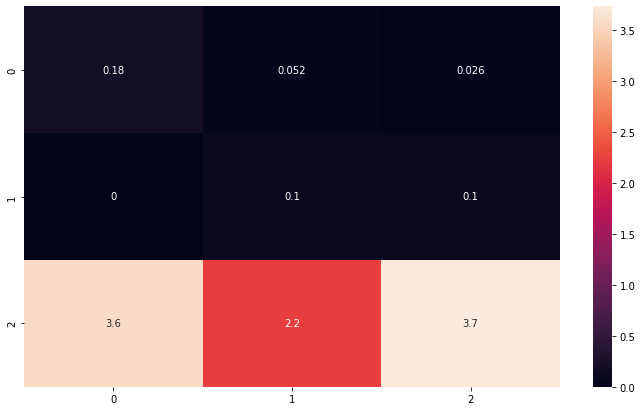

In [194]:
print(len(accuracy))
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
classes = ("0","1","2")
    
cf_matrix = confusion_matrix(y_pred, y_true)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')